# Thuật toán HOG (Histrogram of oriented gradient)

## 1. Sơ lượt thuật toán

Ngày nay, người ta thường sử dụng CNN hoặc các deep learning framework cho nhiệm vụ phát hiện vật thể.<br/> 
Tuy nhiên, đối với một tập dữ liệu nhỏ, sử dụng các kỹ thuật này có thể không phải là lựa chọn tốt nhất, vì kết quả không chính xác và yêu cầu nhiều tài nguyên hơn.<br/> Một phương pháp thay thế là sử dụng mô tả đặc trưng kết hợp với các thuật toán học có giám sát cổ điển như kNN, SVM và Logistic Regression. Phương pháp này nhanh hơn, yêu cầu ít tài nguyên tính toán hơn và cung cấp độ chính xác cao.<br/>

Một trong những mô tả đặc trưng được sử dụng rộng rãi nhất để trích xuất đặc trưng từ dữ liệu hình ảnh là HOG (Histrogram of oriented gradient)

### 1.1 Các bước của HOG

Một số định nghĩa tham số:
- cellSize: Kích thước của một ô (đơn vị pixels)
- blockSize: kích thước của 1 block (đơn vị cell) dùng cho bước chuẩn hóa

#### 1.1.1 Resize lại kích thước ảnh:

Chúng ta sẽ cần resize bức ảnh lại để chia hết cho cellSize.
Dùng thư viện Image có sẵn

#### 1.1.2 Làm xám ảnh

Sau khi đã có ảnh resize biểu diễn dưới dạng RGB. Chúng ta sẽ chuyển thành ảnh xám (grayscale) theo công thức

$$
\begin{aligned}
    gray\_image = 0.299 * red + 0.587 * green + 0.114 * blue
\end{aligned}
$$

#### 1.1.3 Tính gradient magnitude và gradient direction

Tính gradient hướng ngang gx:
$$
\begin{aligned}
g_x = [-1,0,1] * I
\end{aligned}
$$
Tính gradient hướng dọc gy:
$$
\begin{aligned}
g_y = [-1,0,1]^T * I
\end{aligned}
$$
<br/>
Sau đó tính gradient magnitude($g$) và gradient direction($	\theta$):
\begin{aligned}
g = \sqrt{g^2_x + g^2_y} \\
\theta = \arctan \dfrac{g_y}{g_x}
\end{aligned}

#### 1.1.4 Tính vector histogram cho từng ô (cell)

Hình ảnh sẽ được chia thành các lưới ô vuông (cell), mỗi ô vuông (cell) có kích thước cellSize đã định trước.<br/>
Chúng ta sẽ mapping độ lớn gradient vào các bins tương ứng của phương gradient.

Nếu gradient direction không thuộc đầu mút các bin, chúng ta sẽ dùng linear interpolation để chia gradient magnitude vào 2 bin kế nhau.

$$
\begin{aligned}
    x_{l-1} = \frac{x_1-x}{x_1-x_0} * y
\end{aligned}
$$
$$
\begin{aligned}
    x_l = \frac{x-x_0}{x_1-x_0} * y
\end{aligned}
$$
Với x là gradient direction, y là gradient magnitude. x nằm giữa 2 giá trị $[x_0,x_1]$. $x_0$ là đầu mút của bin $l - 1$, $x_1$ là đầu mút của bin $l$

#### 1.1.5 Chuẩn hóa vector histogram với block định sẵn (blocksize)

Sau khi đã có vector histogram của từng cell, ta sẽ chuẩn hóa vector đó theo khối (blockSize) định trước. Nhóm sẽ dùng norm 2 để chuẩn hóa

#### 1.1.6 Bước cuối 

Nối các vector lại với nhau để tạo thành vector HOG. Bước này không cần song song.

## 2. Bản tuần tự

In [1]:
from numba import cuda,float64

import numpy as np
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image
import cv2
import math
import operator

In [2]:
class HOG:
    def __init__(self, blockSize, cellSize, nbins, sbins):
        self.blockSize     = blockSize
        self.cellSize      = cellSize
        self.nbins         = nbins
        self.sbins         = sbins
    def __gray(self):
        picture = self.picture_array
        self.gray = 0.299*picture[:,:,0]+0.587*picture[:,:,1]+0.114*picture[:,:,2]
    def __calc_gradient(self):
        input_   = self.gray
        output_x = np.zeros((self.height,self.width))
        output_y = np.zeros((self.height,self.width))

        for r in range(self.height):
            for c in range(self.width):

                for i in range(-1,2):
                    pixel_r = r + i
                    pixel_r = min(max(0, pixel_r), self.height - 1)
                    output_y[r,c] += input_[pixel_r,c] * i

                    pixel_c = c + i
                    pixel_c = min(max(0, pixel_c), self.width - 1)
                    output_x[r,c] += input_[r,pixel_c] * i
        return output_x, output_y
    def __calc_direc_mag(self):
        self.__gray()
        gradient_x, gradient_y = self.__calc_gradient()
        self.magnitude = np.sqrt(np.square(gradient_x)+np.square(gradient_y))
        self.direction = np.mod(np.add(360, np.rad2deg(np.arctan2(np.array(gradient_y), np.array(gradient_x)))), 360)
    def __cell_hist(self,idx, idy):
        output = np.zeros(9) # output = [0,0,0,0,0,0,0,0,0]

        # duyệt qua kích thước cell theo chiều cao
        for r in range(self.cellSize[0]):
          # duyệt qua kích thước cell theo chiều rộng
            for c in range(self.cellSize[1]):
              # cột và dòng hiện tại trong ảnh
                cur_r = idy*self.cellSize[0] + r
                cur_c = idx*self.cellSize[1] + c
                # kiểm tra
                if cur_r>=self.height or cur_c >= self.width:
                    break

                # chia lấy phần nguyên và phần dư
                quotient = int(self.direction[cur_r][cur_c]//self.sbins)
                remainder = self.direction[cur_r][cur_c] % self.sbins

                if remainder==0:
                    output[quotient] += self.magnitude[cur_r][cur_c]
                else:
                    first_bin = quotient

                    second_bin = first_bin+1

                    output[first_bin] += self.magnitude[cur_r][cur_c]*\
                        ((second_bin*self.sbins - self.direction[cur_r][cur_c])/ \
                                         (second_bin*self.sbins - first_bin*self.sbins))

                    second_bin_idx = second_bin
                    if second_bin > 8:
                        second_bin_idx = 0
                    output[second_bin_idx] += self.magnitude[cur_r][cur_c]*\
                        ((self.direction[cur_r][cur_c] - first_bin*self.sbins)/(second_bin*self.sbins - first_bin*self.sbins))
        return output

    def __all_hist(self):
        hist = []
        for y in range(0,self.n_cell[0]):
            row = []
            for x in range(0,self.n_cell[1]):
                output = self.__cell_hist(x,y)
                row.append(output)
            hist.append(row)
        self.hist = np.array(hist)

        
    def compute_HOG(self, picture):
        self.picture_array = picture
        self.height, self.width, self.channel = self.picture_array.shape
        self.n_cell  = (self.height//self.cellSize[0], self.width//self.cellSize[1])
        self.n_block = (self.n_cell[0] - self.blockSize[0] + 1, self.n_cell[1] - self.blockSize[1] + 1)
        
        self.__calc_direc_mag()
        self.__all_hist()
        norm_array_size = self.n_block[0] * self.n_block[1] * self.blockSize[0] * self.blockSize[1] * self.nbins
        l2 = np.empty(self.n_block)
        for i in range(self.n_block[0]):
            for j in range(self.n_block[1]):
                l2[i][j] = math.sqrt(np.sum(np.square(self.hist[i:i+2, j:j+2])))
        norm_block = np.zeros((self.n_block[0], self.n_block[1], self.blockSize[0], self.blockSize[1], self.nbins))
        for y in range(self.n_block[0]):
            for x in range(self.n_block[1]):
                out = self.hist[y: y + self.blockSize[0], x: x + self.blockSize[1]] / (l2[y][x] + 1)
                norm_block[y][x] = out
        self.HOG        = norm_block.flatten()
        self.norm_block = norm_block
        return self.HOG

## 3. Song song - Version 1

Ở bản song song 1, nhóm chỉ song song bước
- `1.1.2 Làm xám ảnh`
- `1.1.3 Tính gradient hướng ngang gx, hướng dọc gy`, sau khi tính gx, gy thì tính direction và magnitude dùng numpy tuần tự.
- `1.1.4 Tính vector histogram cho từng ô`
- `1.1.5 Chuẩn hóa vector của các block`
<br/>
Bước tính L2 dùng để chuẩn hóa nhóm làm tuần tự.

In [3]:
class HOG_CUDA:
    def __init__(self, blockSize, cellSize, nbins, sbins, threadsperblock):
        self.blockSize = blockSize
        self.cellSize = cellSize
        self.nbins = nbins
        self.sbins = sbins
        self.threadsperblock = threadsperblock

    @staticmethod
    @cuda.jit
    def __gray_kernel(input, width, height, channel, gray):
        row, col = cuda.grid(2)
        if row >= height or col >= width or channel != 3:
            return
        rgb = input[row][col]
        gray[row][col] = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]

    def __gray(self):
        picture = self.picture_array
        # Memory Allocation
        blockspergrid_x = math.ceil(self.picture_array.shape[0] / self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.picture_array.shape[1] / self.threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        gray_dev = np.empty([self.height, self.width], dtype=float)
        input_dev = cuda.to_device(self.picture_array)
        gray_device = cuda.device_array_like(gray_dev)
        kernel = self.__gray_kernel
        kernel[blockspergrid, self.threadsperblock](input_dev, self.width, self.height, self.channel, gray_device)
        gray_dev = gray_device.copy_to_host()
        self.gray = gray_dev

    @staticmethod
    @cuda.jit
    def __calc_gradient_kernel(input, width, height, output_x, output_y):
        row, col = cuda.grid(2)
        if (row >= height) or (col >= width):
            return
        for i in range(-1, 2):
            pixel_r = row + i
            pixel_r = min(max(0, pixel_r), height - 1)
            output_y[row, col] += input[pixel_r, col] * i

            pixel_c = col + i
            pixel_c = min(max(0, pixel_c), width - 1)
            output_x[row, col] += input[row, pixel_c] * i

    def __calc_gradient(self):
        blockspergrid_x = math.ceil(self.picture_array.shape[0] / self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.picture_array.shape[1] / self.threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        gradient_x_dev = np.zeros((self.height, self.width))
        gradient_y_dev = np.zeros((self.height, self.width))

        gradient_x_device = cuda.to_device(gradient_x_dev)
        gradient_y_device = cuda.to_device(gradient_y_dev)
        gray_device = cuda.to_device(self.gray)
        self.__calc_gradient_kernel[blockspergrid, self.threadsperblock] \
            (gray_device, self.width, self.height, gradient_x_device, gradient_y_device)

        gradient_x_dev = gradient_x_device.copy_to_host()
        gradient_y_dev = gradient_y_device.copy_to_host()
        return gradient_x_dev, gradient_y_dev

    def __calc_direc_mag(self):
        self.__gray()
        gradient_x, gradient_y = self.__calc_gradient()
        self.magnitude = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
        self.direction = np.mod(np.add(360, np.rad2deg(np.arctan2(np.array(gradient_y), np.array(gradient_x)))), 360)

    @staticmethod
    @cuda.jit
    def __hist_kernel(direction, magnitude, width, height, sbin, cell_size, result_out):
        cur_r, cur_c = cuda.grid(2)

        idy = int(cur_r // cell_size[0])
        idx = int(cur_c // cell_size[1])
        # kiểm tra
        if cur_r >= height or cur_c >= width:
            return
        thread_direction = direction[cur_r][cur_c]
        thread_mag = magnitude[cur_r][cur_c]
        # chia lấy phần nguyên và phần dư
        quotient = int(thread_direction // sbin)
        remainder = thread_direction % sbin

        if remainder == 0:
            cuda.atomic.add(result_out, (idy, idx, quotient), thread_mag)
        else:
            first_bin = quotient

            second_bin = first_bin + 1
            need_to_add = thread_mag * ((second_bin * sbin - thread_direction) / (second_bin * sbin - first_bin * sbin))
            cuda.atomic.add(result_out, (idy, idx, first_bin), need_to_add)

            second_bin_idx = second_bin
            if second_bin > 8:
                second_bin_idx = 0
            need_to_add_2 = thread_mag * (
                        (thread_direction - first_bin * sbin) / (second_bin * sbin - first_bin * sbin))
            cuda.atomic.add(result_out, (idy, idx, second_bin_idx), need_to_add_2)

    def __all_hist(self):
        blockspergrid_x = math.ceil(self.picture_array.shape[0] / self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.picture_array.shape[1] / self.threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        hist_dev = np.empty([self.n_cell[0], self.n_cell[1], self.nbins], dtype=np.float64)
        d_direction = cuda.to_device(self.direction)
        d_magnitude = cuda.to_device(self.magnitude)
        d_cell_size = cuda.to_device(self.cellSize)
        hist_device = cuda.device_array_like(hist_dev)
        kernel = self.__hist_kernel
        kernel[blockspergrid, self.threadsperblock] \
            (d_direction, d_magnitude, self.width, self.height, self.sbins, d_cell_size, hist_device)
        self.hist = hist_device.copy_to_host()

    @staticmethod
    @cuda.jit()
    def __normalize_kernel(hist, n_block, block_size, l2, normed):
        row, col = cuda.grid(2)
        if row >= n_block[0] or col >= n_block[1]:
            return
        for y in range(block_size[0]):
            for x in range(block_size[1]):
                for i in range(9):
                    normed[row][col][y][x][i] = hist[row + y][col + x][i] / (l2[row][col] + 1)

    def compute_HOG(self, picture):

        self.picture_array = picture
        self.height, self.width, self.channel = self.picture_array.shape
        self.n_cell = (self.height // self.cellSize[0], self.width // self.cellSize[1])
        self.n_block = (self.n_cell[0] - self.blockSize[0] + 1, self.n_cell[1] - self.blockSize[1] + 1)

        self.__calc_direc_mag()
        self.__all_hist()

        norm_array_size = self.n_block[0] * self.n_block[1] * self.blockSize[0] * self.blockSize[1] * self.nbins
        l2 = np.empty(self.n_block)

        for i in range(self.n_block[0]):
            for j in range(self.n_block[1]):
                l2[i][j] = math.sqrt(np.sum(np.square(self.hist[i:i + 2, j:j + 2])))

        norm_block = np.zeros((self.n_block[0], self.n_block[1], self.blockSize[0], self.blockSize[1], self.nbins))
        normed_device = cuda.to_device(norm_block)
        l2_dev = cuda.to_device(l2)
        hist_device = cuda.to_device(self.hist)
        n_block_device = cuda.to_device(self.n_block)

        blockspergrid_x = math.ceil(self.picture_array.shape[0] / self.blockSize[0])
        blockspergrid_y = math.ceil(self.picture_array.shape[1] / self.blockSize[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)

        self.__normalize_kernel[blockspergrid, self.threadsperblock] \
            (hist_device, n_block_device, self.blockSize, l2_dev, normed_device)
        norm_block = normed_device.copy_to_host()

        self.HOG = norm_block.flatten()
        self.norm_block = norm_block
        return self.HOG

## 3. Song song - Version 2

Ở bản này, nhóm giữ nguyên kernel song song bước `Làm xám ảnh` và `Chuẩn hóa vector của các block`.<br/>
Các cải tiến:
- `Bước 1.1.3` Nhóm sẽ gộp tính direction và magnitude vào trong kernel song song luôn chứ không dùng numpy tuần tự để tính nữa.
- `Bước 1.1.4` Nhóm sẽ dùng shared memory để tính histogram của từng cell, thêm vào đó cũng tính luôn tổng bình phương của vector histogram dùng cho tính L2 ở bước sau
- Nhóm sẽ thêm 1 kernel song song để tính L2 của từng block dựa vào tổng bình phương vector histogram ở bước trước.
Như vậy sẽ tạo thành 1 quy trình hoàn chỉnh trên GPU CUDA, hạn chế tối đa thời gian đọc ghi giữa các bước.

In [4]:
class HOG_CUDA_2:
    def __init__(self, blockSize, cellSize, nbins, sbins, threadsperblock):
        self.blockSize = blockSize
        self.cellSize = cellSize
        self.nbins = nbins
        self.sbins = sbins
        self.threadsperblock = threadsperblock
        self.x_Dim = self.threadsperblock[0] // self.cellSize[0]
        self.y_Dim = self.threadsperblock[1] // self.cellSize[1]

    @staticmethod
    @cuda.jit
    def __gray_kernel(input, width, height, channel, gray):
        row, col = cuda.grid(2)
        if row >= height or col >= width or channel != 3:
            return
        rgb = input[row][col]
        gray[row][col] = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]

    def __gray(self):
        picture = self.picture_array
        # Memory Allocation
        blockspergrid_x = math.ceil(self.picture_array.shape[0] / self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.picture_array.shape[1] / self.threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        gray_dev = np.empty([self.height, self.width], dtype=float)
        input_dev = cuda.to_device(self.picture_array)
        gray_device = cuda.device_array_like(gray_dev)
        kernel = self.__gray_kernel
        kernel[blockspergrid, self.threadsperblock](input_dev, self.width, self.height, self.channel, gray_device)
        self.gray = gray_device

    @staticmethod
    @cuda.jit
    def __calc_gradient_kernel_2(input, width, height, magnitude, direction):
        row, col = cuda.grid(2)
        y = 0.0
        x = 0.0
        if (row >= height) or (col >= width):
            return
        for i in range(-1, 2):
            pixel_r = row + i
            pixel_r = min(max(0, pixel_r), height - 1)
            y += input[pixel_r, col] * i

            pixel_c = col + i
            pixel_c = min(max(0, pixel_c), width - 1)
            x += input[row, pixel_c] * i

        magnitude[row, col] = math.sqrt(y ** 2 + x ** 2)
        direction[row, col] = operator.mod((360 + math.atan2(y, x) * 180 / math.pi), 360)

    def __calc_gradient(self):
        blockspergrid_x = math.ceil(self.picture_array.shape[0] / self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.picture_array.shape[1] / self.threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)

        mag_dev = np.zeros((self.height, self.width))
        dir_dev = np.zeros((self.height, self.width))

        mag_device = cuda.to_device(mag_dev)
        dir_device = cuda.to_device(dir_dev)

        self.__calc_gradient_kernel_2[blockspergrid, self.threadsperblock] \
            (self.gray, self.width, self.height, mag_device, dir_device)

        return mag_device, dir_device

    def __calc_direc_mag(self):
        self.__gray()
        mag_device, dir_device = self.__calc_gradient()
        self.magnitude = mag_device
        self.direction = dir_device

    @staticmethod
    @cuda.jit()
    def __hist_kernel(direction, magnitude, cell_size, d_sbin, result_out, out_l2, x_Dim, y_Dim, nbins):
        cur_r, cur_c = cuda.grid(2)
        height, width = direction.shape

        idy = int(cur_r // cell_size[0])
        idx = int(cur_c // cell_size[1])
        sbin = d_sbin

        # Creat 3D shared array
        shared = cuda.shared.array(shape=(4, 4, 9), dtype=float64)
        l2 = cuda.shared.array(shape=(4, 4), dtype=float64)
        idy_shared = idy % x_Dim
        idx_shared = idx % y_Dim

        condition_1 = cur_r % cell_size[0]
        condition_2 = int(cur_c % (cell_size[1]))
        if condition_1 == 0:
            check = condition_2
            if check < 8:
                shared[idy_shared][idx_shared][check] = 0.0
        elif condition_1 == 1:
            check = condition_2
            if check == 0:
                shared[idy_shared][idx_shared][8] = 0.0
                l2[idy_shared][idx_shared] = 0.0

        cuda.syncthreads()
        # kiểm tra
        if cur_r >= height or cur_c >= width:
            return
        thread_direction = direction[cur_r][cur_c]
        thread_mag = magnitude[cur_r][cur_c]
        # chia lấy phần nguyên và phần dư
        quotient = int(thread_direction // sbin)
        remainder = thread_direction % sbin

        if remainder == 0:
            cuda.atomic.add(shared, (idy_shared, idx_shared, quotient), thread_mag)

        else:
            first_bin = quotient
            second_bin = first_bin + 1
            need_to_add = thread_mag * ((second_bin * sbin - thread_direction) / sbin)
            cuda.atomic.add(shared, (idy_shared, idx_shared, first_bin), need_to_add)

            second_bin_idx = second_bin
            if second_bin > 8:
                second_bin_idx = 0
            need_to_add_2 = thread_mag * ((thread_direction - first_bin * sbin) / sbin)

            cuda.atomic.add(shared, (idy_shared, idx_shared, second_bin_idx), need_to_add_2)

        cuda.syncthreads()

        if condition_1 == 0:
            check = condition_2
            if check < 8:
                result_out[idy][idx][check] = shared[idy_shared][idx_shared][check]
                cuda.atomic.add(l2, (idy_shared, idx_shared), shared[idy_shared][idx_shared][check] ** 2)
        elif condition_1 == 1:
            if check == 0:
                cuda.atomic.add(l2, (idy_shared, idx_shared), shared[idy_shared][idx_shared][8] ** 2)
                result_out[idy][idx][8] = shared[idy_shared][idx_shared][8]
                cuda.syncthreads()
                out_l2[idy][idx] = l2[idy_shared][idx_shared]
        else:
            return

    def __all_hist(self):
        blockspergrid_x = math.ceil(self.direction.shape[0] / self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.direction.shape[1] / self.threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)

        hist_dev = np.empty([self.n_cell[0], self.n_cell[1], self.nbins], dtype=np.float64)
        l2_dev = np.empty([self.n_cell[0], self.n_cell[1]], dtype=np.float64)
        d_cell_size = cuda.to_device(self.cellSize)
        hist_device = cuda.device_array_like(hist_dev)
        l2_device = cuda.device_array_like(l2_dev)
        kernel = self.__hist_kernel
        kernel[blockspergrid, self.threadsperblock] \
            (self.direction, self.magnitude, d_cell_size, self.sbins, hist_device, l2_device, \
             self.x_Dim, self.y_Dim, self.nbins)
        self.hist = hist_device
        self.test = hist_device.copy_to_host()
        self.l2_sum = l2_device

    @staticmethod
    @cuda.jit()
    def __l2_kernel(l2_hist, n_block, final_l2):
        row, col = cuda.grid(2)
        if row >= n_block[0] or col >= n_block[1]:
            return
        need_to_sum = l2_hist[row:row + 2, col:col + 2]
        sum_result = 0.0
        for i in range(2):
            for j in range(2):
                sum_result += need_to_sum[i][j]
        final_l2[row][col] = math.sqrt(sum_result)

    @staticmethod
    @cuda.jit()
    def __normalize_kernel(hist, n_block, block_size, l2, normed):
        row, col = cuda.grid(2)
        if row >= n_block[0] or col >= n_block[1]:
            return
        for y in range(block_size[0]):
            for x in range(block_size[1]):
                for i in range(9):
                    normed[row][col][y][x][i] = hist[row + y][col + x][i] / (l2[row][col] + 1)

    def compute_HOG(self, picture):

        self.picture_array = picture
        self.height, self.width, self.channel = self.picture_array.shape
        self.n_cell = (self.height // self.cellSize[0], self.width // self.cellSize[1])
        self.n_block = (self.n_cell[0] - self.blockSize[0] + 1, self.n_cell[1] - self.blockSize[1] + 1)

        self.__calc_direc_mag()
        self.__all_hist()

        blockspergrid_x = math.ceil(self.n_block[0] / self.threadsperblock[0])
        blockspergrid_y = math.ceil(self.n_block[1] / self.threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)

        norm_array_size = self.n_block[0] * self.n_block[1] * self.blockSize[0] * self.blockSize[1] * self.nbins
        final_l2 = np.empty([self.n_block[0], self.n_block[1]], dtype=np.float64)
        device_l2 = cuda.device_array_like(final_l2)
        self.__l2_kernel[blockspergrid, self.threadsperblock](self.l2_sum, self.n_block, device_l2)
        self.l2 = device_l2

        norm_block = np.zeros((self.n_block[0], self.n_block[1], self.blockSize[0], self.blockSize[1], self.nbins))
        normed_device = cuda.to_device(norm_block)

        self.__normalize_kernel[blockspergrid, self.threadsperblock] \
            (self.hist, self.n_block, self.blockSize, self.l2, normed_device)
        norm_block = normed_device.copy_to_host()

        self.HOG = norm_block.reshape(norm_array_size)
        self.norm_block = norm_block
        return self.HOG

## 4. So sánh thời gian chạy

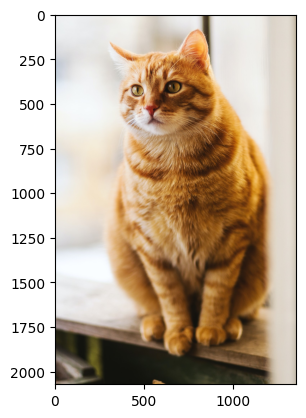

In [5]:
cell_size = (8, 8)
block_size = (2, 2)
img = Image.open('./cat-1.jpg')
new_width  =  img.size[0] // cell_size[0] * cell_size[0]
new_height =  img.size[1] // cell_size[1] * cell_size[1]
img = img.resize((new_width,new_height), Image.LANCZOS)
img_pixel = np.array(img)
plt.imshow(img_pixel)

##### Bản tuần tự

In [20]:
cell_size = (8, 8)
block_size = (2, 2)
nbins = 9
a = HOG(block_size, cell_size, nbins, 40)

In [21]:
%timeit a.compute_HOG(img_pixel)

18.5 s ± 126 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Bản song song - ver 1

In [22]:
threadsperblock = (32,32)
b = HOG_CUDA(block_size, cell_size, nbins, 40,threadsperblock )

In [23]:
%timeit b.compute_HOG(img_pixel)

452 ms ± 35.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


##### Bản song song - ver 2

In [24]:
threadsperblock = (32,32)
c = HOG_CUDA_2(block_size, cell_size, nbins, 40,threadsperblock )

In [25]:
%timeit c.compute_HOG(img_pixel)

33.8 ms ± 301 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


##### Thư viện

In [29]:
def gray_host(input, channel):
    if channel==1:
        return
    return 0.299*input[:,:,0]+0.587*input[:,:,1]+0.114*input[:,:,2]

In [30]:
from skimage import feature
gray = gray_host(img_pixel,3)
%timeit feature.hog(gray, orientations=9, pixels_per_cell=(8, 8), \
                cells_per_block=(2, 2), transform_sqrt=False, block_norm="L2",channel_axis=None)

571 ms ± 6.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ở đây, nhóm đã đưa ảnh xám sẵn cho thư viện chạy nên thời gian có thể không chính xác lắm. Còn kernel của nhóm phải tính luôn thời gian làm xám ảnh.

Chúng ta có thể thấy sự cải thiện rõ rệt

| Phiên bản   | Thời gian chạy            |
|-------------|---------------------------|
| Tuần tự     | 18.5 s ± 126 ms per loop  |
| Thư viện    | 571 ms ± 6.33 ms per loop |
| Song song 1 | 452 ms ± 35.2 ms per loop |
| Song song 2 | 33.8 ms ± 301 µs per loop |

## 5. Nguồn tham khảo

[Analyticsvidhya](https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/)
<br/>
[Wikipedia](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)
<br/>
[Scikit-image](https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog)
<br/>
[LearnOpenCV](https://learnopencv.com/histogram-of-oriented-gradients/)
<br/>
[Viblo](https://viblo.asia/p/tim-hieu-ve-phuong-phap-mo-ta-dac-trung-hog-histogram-of-oriented-gradients-V3m5WAwxZO7)